# Characterizing the Hypergraph-of-Entity with Synonyms

This representation model uses a weighted mixed hypergraph. Dependending on the version, the weights can be unitary constants. All versions combine directed and undirected hyperedges.

Possible node classes include:

- TermNode
- EntityNode

Possible hyperedge classes include:

- DocumentEdge
- ContainedInEdge
- RelatedToEdge
- SynonymEdge
- ContextEdge

In order to run the notebook, you must first obtain the corresponding CSV files through the `inspect` command in Army ANT. For example:

```bash
./army-ant.py inspect \
    --index-location=/opt/army-ant/indexes/inex-2009-10t-nl/hgoe \
    --index-type=hgoe \
    --workdir=/opt/army-ant/analysis/inex_2009_10t_nl-stats \
    --feature=export-node-degrees
```

You must then put the resulting files into the `data` directory for the collection and index version. For example `data/inex_2009_10t_nl/base_model` for the Hypergraph-of-Entity Base Model over the INEX 2009 3T-NL subset test collection. You should then configure the `base_dir` below accordingly. Bash scripts are provided in directory `runs/inex-2009-10t-nl/hgoe/nb-characterization`, in order to generate the required files.

In [1]:
if (!require("pacman")) install.packages("pacman")

pacman::p_load(
    tidyverse,
    logging,
    scales,
    repr,
    xtable
)

basicConfig()
options(warn=-1)
options(scipen=0)
options(xtable.include.rownames=FALSE)

base_dir <- "data/inex_2009_10t_nl/syns"

Loading required package: pacman


## Node degree and hyperedge cardinality distributions

We define a degree data loading function for a given `base_dir`, beautifying the node and hyperedge type labels (i.e., transforming from the Java class identifier to the node or hyperedge label used in the theory).

In [2]:
load_node_degree_data <- function(base_dir) {
    nodes_path <- file.path(base_dir, list.files(path = base_dir, pattern = "node-degree-.*\\.csv"))

    nodes <- setNames(
        read.csv(nodes_path, stringsAsFactors = F),
        c("node_id", "type", "name", "v_degree", "e_degree", "in_v_degree", "out_v_degree",
          "in_e_degree", "out_e_degree", "dir_in_v_degree", "dir_out_v_degree",
          "dir_in_e_degree", "dir_out_e_degree"))
    
    nodes[which(nodes$type == "EntityNode"), "type"] <- "entity"
    nodes[which(nodes$type == "TermNode"), "type"] <- "term"
 
    nodes
}

load_edge_cardinality_data <- function(base_dir) {
    edges_path <- file.path(base_dir, list.files(path = base_dir, pattern = "edge-cardinality-.*\\.csv"))

    edges <- setNames(
        read.csv(edges_path, stringsAsFactors = F),
        c("edge_id", "type", "is_directed", "cardinality", "undirected_cardinality",
          "tail_cardinality", "head_cardinality"))
    
    edges$is_directed <- edges$is_directed == "true"
    
    edges[which(edges$type == "DocumentEdge"), "type"] <- "document"
    edges[which(edges$type == "ContainedInEdge"), "type"] <- "contained_in"
    edges[which(edges$type == "RelatedToEdge"), "type"] <- "related_to"
    edges[which(edges$type == "SynonymEdge"), "type"] <- "synonym"
    edges[which(edges$type == "ContextEdge"), "type"] <- "context"
 
    edges
}

A hypergraph has two degree distributions, one for the nodes and another one for the hyperedges. We look at both.

In [3]:
node_degree <- load_node_degree_data(file.path(base_dir, "global"))
head(node_degree %>% arrange(desc(v_degree)))

node_id,type,name,v_degree,e_degree,in_v_degree,out_v_degree,in_e_degree,out_e_degree,dir_in_v_degree,dir_out_v_degree,dir_in_e_degree,dir_out_e_degree
<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
477,term,also,537951,5392,537951,537951,5384,5392,0,8,0,8
746,term,new,522940,5692,522938,522940,4216,5692,0,1476,0,1476
312,term,on,512366,5141,512262,512366,4431,5141,0,710,0,710
959,term,first,509038,4471,509036,509038,4119,4471,0,352,0,352
306,term,time,492103,4463,492102,492103,4041,4463,0,422,0,422
1026,term,refer,484452,4701,484452,484452,4700,4701,0,1,0,1


In [4]:
edge_cardinality <- load_edge_cardinality_data(file.path(base_dir, "global"))
head(edge_cardinality)
edge_cardinality %>%
    group_by(type) %>%
    summarise(max_cardinality=max(cardinality))

edge_id,type,is_directed,cardinality,undirected_cardinality,tail_cardinality,head_cardinality
<int>,<chr>,<lgl>,<int>,<int>,<int>,<int>
0,document,FALSE,853,853,0,0
1,document,FALSE,56,56,0,0
2,document,FALSE,404,404,0,0
3,document,FALSE,364,364,0,0
4,related_to,FALSE,4,4,0,0
5,related_to,FALSE,20,20,0,0


type,max_cardinality
<chr>,<int>
contained_in,16
document,8167
related_to,3084
synonym,9


We define a degree plotting function that takes the raw CSV, calculates the degree frequency and displays a point plot with a facet for each node or hyperedge type.

In [5]:
plot_degree_per_type <- function(data, label, name="degree") {
    data <- data %>%
        count(type, !!sym(name), sort=TRUE)

    ggplot(data, aes_string(x=name, y="n")) +
        facet_wrap(~type) +
        geom_point(size=0.5) +
        scale_x_log10() + 
        scale_y_log10(limits=c(1,max(data$Freq))) +
        xlab(label) +
        ylab("Frequency")
}

### Node degree distributions

As we can see, the node node degree distribution in the hypergraph-of-entity does not follow a power law, despite having a long tail.

In [6]:
options(repr.plot.width=4.5, repr.plot.height=2)

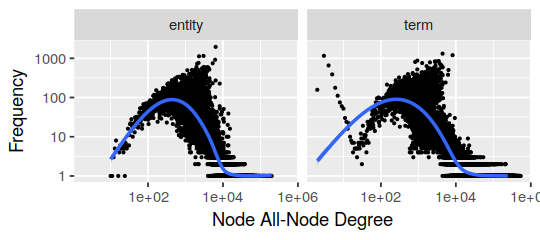

In [7]:
plot_degree_per_type(node_degree, "Node All-Node Degree", "v_degree") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))
ggsave(filename = "output/syns/node_all_node_degree.png", width = 4.5, height = 2, dpi = 300)

Let's look a the distribution for the number of synonyms from WordNet nouns, to see if it explains the added power law at the beginning of the term node degree distribution.

In [8]:
wn_syns_distr <- read_csv("data/wordnet-noun-syns-distr-20200130T135115.csv", col_types = cols())
head(wn_syns_distr)

Word,SynsCount
<chr>,<dbl>
'hood,1
's_Gravenhage,3
.22,2
0,5
1,6
1-dodecanol,2


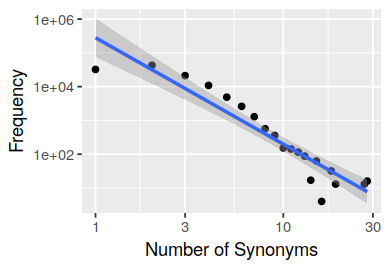

In [9]:
options(repr.plot.width=3.25, repr.plot.height=2.25)
ggplot(wn_syns_distr %>% count(SynsCount), aes(x=SynsCount, y=n)) +
    geom_point() +
    scale_x_log10() +
    scale_y_log10() +
    stat_smooth(method="lm") +
    labs(x="Number of Synonyms", y="Frequency")
ggsave(filename = "output/syns/wordnet_noun_syns_distr.png", width = 3, height = 2, dpi = 300)

However, the hyperedge node degree distribution, slightly approximates a power law.

In [10]:
options(repr.plot.width=4.5, repr.plot.height=2)

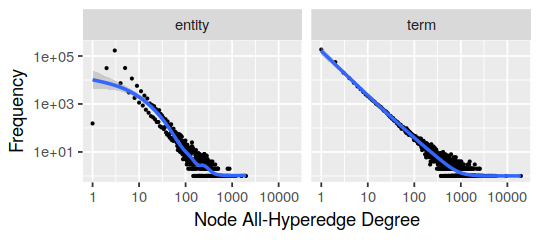

In [11]:
plot_degree_per_type(node_degree, "Node All-Hyperedge Degree", "e_degree") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))
ggsave(filename = "output/syns/node_all_hyperedge_degree.png", width = 4.5, height = 2, dpi = 300)

#### Node degree distributions based on directed hyperedges

If we only consider directed hyperedges, the node incoming-node degree does not follow a power law.

In [12]:
options(repr.plot.width=3.25, repr.plot.height=2.25)

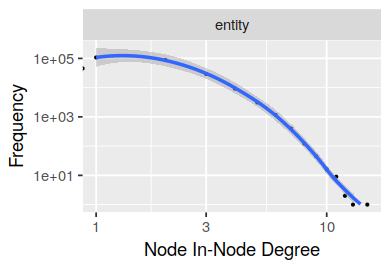

In [13]:
plot_degree_per_type(node_degree[node_degree$type == "entity", ], "Node In-Node Degree", "dir_in_v_degree") +
    stat_smooth(method = "loess")

For directed hyperedges, the node outgoing-node degree approximates a power law, although it is more heavy-tailed.

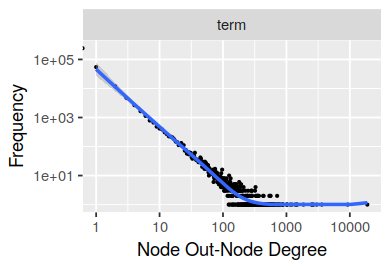

In [14]:
plot_degree_per_type(node_degree[node_degree$type == "term", ], "Node Out-Node Degree", "dir_out_v_degree") +
    stat_smooth(method = "loess")

For directed hyperedges, the node incoming-hyperedge degree is always one.

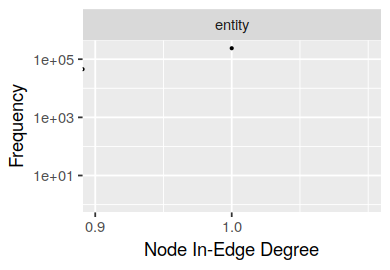

In [15]:
plot_degree_per_type(node_degree[node_degree$type == "entity", ], "Node In-Edge Degree", "dir_in_e_degree") +
    stat_smooth(method = "loess")

For directed hyperedges, the node outgoing-node degree, approximates a power law, although it is more heavy-tailed.

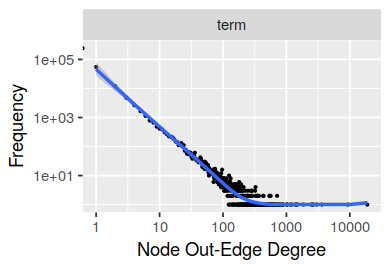

In [16]:
plot_degree_per_type(node_degree[node_degree$type == "term", ], "Node Out-Edge Degree", "dir_out_e_degree") +
    stat_smooth(method = "loess")

### Hyperedge cardinality distributions

The hyperedge cardinality distributions do not follow power laws, with the `contained_in` hyperedges having less nodes than `document` or `related_to` hyperedges. This is expected, as `contained_in` hyperedges usually link a few `term` nodes to its corresponding `entity` node.

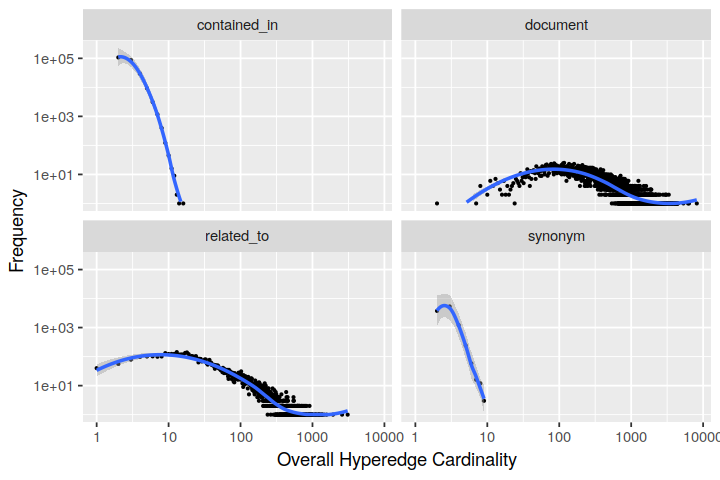

In [17]:
options(repr.plot.width=6, repr.plot.height=4)
plot_degree_per_type(edge_cardinality, "Overall Hyperedge Cardinality", "cardinality") +
    stat_smooth(method = "loess")
    #stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))
ggsave(filename = "output/syns/hyperedge_overall_cardinality.png", width = 6, height = 4, dpi = 300)

In [18]:
options(repr.plot.width=3.25, repr.plot.height=2.25)

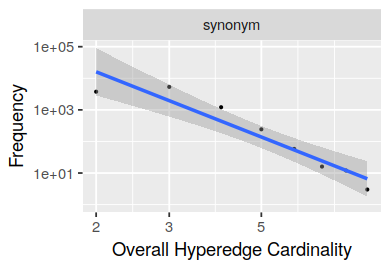

In [19]:
plot_degree_per_type(edge_cardinality %>% filter(type == "synonym"),
                     "Overall Hyperedge Cardinality", "cardinality") +
    stat_smooth(method = "lm")
ggsave(filename = "output/syns/hyperedge_synonym_overall_cardinality.png", width = 3, height = 2, dpi = 300)

#### Hyperedge cardinality distribution based on directed hyperedges

If we only consider directed hyperedges, the tail cardinality has the following non-power-law distribution.

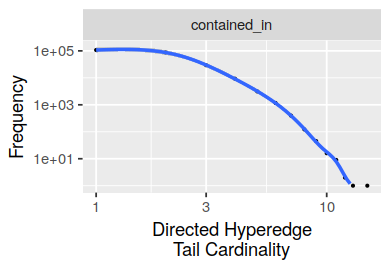

In [20]:
plot_degree_per_type(edge_cardinality[edge_cardinality$type == "contained_in", ],
                     "Directed Hyperedge\nTail Cardinality", "tail_cardinality") +
    #scale_x_continuous() +
    #scale_y_continuous() +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))

For directed hyperedges, the head cardinality is always one.

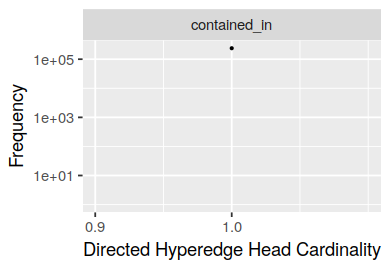

In [21]:
plot_degree_per_type(edge_cardinality[edge_cardinality$type == "contained_in", ],
                     "Directed Hyperedge Head Cardinality", "head_cardinality") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))

## Top 10 nodes

### Node incoming-node degree

In [22]:
top_10_terms_by_incoming_node_degree <- node_degree %>%
    filter(type == "term") %>%
    group_by(node_id) %>%
    summarise(name=max(name), in_v_degree=sum(in_v_degree)) %>%
    arrange(desc(in_v_degree)) %>%
    head(10)
top_10_terms_by_incoming_node_degree

node_id,name,in_v_degree
<int>,<chr>,<int>
477,also,537951
746,new,522938
312,on,512262
959,first,509036
306,time,492102
1026,refer,484452
588,see,482742
951,state,478696
700,link,475903


In [23]:
top_10_entities_by_incoming_node_degree <- node_degree %>%
    filter(type == "entity") %>%
    group_by(node_id) %>%
    summarise(name=max(name), in_v_degree=sum(in_v_degree)) %>%
    arrange(desc(in_v_degree)) %>%
    head(10)
top_10_entities_by_incoming_node_degree

node_id,name,in_v_degree
<int>,<chr>,<int>
1078,United States,199796
148,India,174817
27,Japan,154539
3649,France,146492
3287,2007,136161
3612,World War II,134358
3610,Germany,133949
3295,2006,130566
14808,Russia,126066


### Node incoming-hyperedge degree

In [24]:
top_10_terms_by_incoming_hyperedge_degree <- node_degree %>%
    filter(type == "term") %>%
    group_by(node_id) %>%
    summarise(name=max(name), in_e_degree=sum(in_e_degree)) %>%
    arrange(desc(in_e_degree)) %>%
    head(10)
top_10_terms_by_incoming_hyperedge_degree

node_id,name,in_e_degree
<int>,<chr>,<int>
477,also,5384
1026,refer,4700
700,link,4557
699,extern,4465
312,on,4431
746,new,4216
959,first,4119
306,time,4041
588,see,3996


In [25]:
top_10_entities_by_incoming_hyperedge_degree <- node_degree %>%
    filter(type == "entity") %>%
    group_by(node_id) %>%
    summarise(name=max(name), in_e_degree=sum(in_e_degree)) %>%
    arrange(desc(in_e_degree)) %>%
    head(10)
top_10_entities_by_incoming_hyperedge_degree

node_id,name,in_e_degree
<int>,<chr>,<int>
1078,United States,1984
5590,Scientific classification,1596
148,India,1587
27,Japan,1205
8734,Dinosaur,1129
3287,2007,1009
3295,2006,1005
3649,France,984
3610,Germany,922


## Global statistics

In [26]:
load_stats_data <- function(base_dir, as_list=FALSE) {
    stats_path <- file.path(base_dir, list.files(path = base_dir, pattern = "stats-.*\\.csv"))

    stats <- read.csv(stats_path, stringsAsFactors = F)
    
    stats
}

In [27]:
stats <- rbind(
    load_stats_data(file.path(base_dir, "global")),
    data.frame(
        Statistic=c(
            "Term Vertices",
            "Entity Vertices",
            "contained_in Hyperedges",
            "document Hyperedges",
            "related_to Hyperedges",
            "synonym Hyperedges"
        ),
        Value=c(
            nrow(node_degree[node_degree$type == "term", ]),
            nrow(node_degree[node_degree$type == "entity", ]),
            nrow(edge_cardinality[edge_cardinality$type == "contained_in", ]),
            nrow(edge_cardinality[edge_cardinality$type == "document", ]),
            nrow(edge_cardinality[edge_cardinality$type == "related_to", ]),
            nrow(edge_cardinality[edge_cardinality$type == "synonym", ])
        )
    ))
stats
#print(xtable(stats, digits = 10))

Statistic,Value
<chr>,<dbl>
Vertices,6.102120e+05
Directed Hyperedges,2.382160e+05
Undirected Hyperedges,2.558800e+04
Total Hyperedges,2.638040e+05
Num Sources,0.000000e+00
Num Sinks,0.000000e+00
Density,3.878929e-06
Avg. Degree,8.646307e-01
Min InEdge Degree,1.000000e+00


## Scalability

In order to better understand the impact of adding more documents and entities to the index, we created several snapshots by limiting the number of documents read from INEX 2009 3T-NL subset test collection. We then obtained the following aggregated statistics from each snapshot studying their evolution for an increasing number of documents:

- Average node degree;
 - Average node incoming edge degree;
 - Average node outgoing edge degree;
 - Average node incoming node degree;
 - Average node outgoing node degree;
- Average hyperedge cardinality;
 - Average cardinality for undirected hyperedges;
 - Average tail cardinality for directed hyperedges;
 - Average head cardinality for directed hyperedges;
- Estimated clustering coefficient;
- Estimated average path length and diameter;
- General mixed hypergraph density;
- Size and space usage;
 - Number of nodes;
 - Number of hyperedges;
 - Number of bytes in disk;
 - Number of bytes in memory.

We will begin by the node and hyperedge degree. In order to generate the required data, run the scripts in `runs/inex-2009-3t-nl/hgoe/scalability` in order. This will generate indices with a progressively larger number of documents, using the `--limit` argument (snapshots). Inspect will then generate the node and edge degree distributions per index snapshot, properly organizing them in a directory with name `snapshot_<id>_<num_docs>`.

In [28]:
options(repr.plot.width=4, repr.plot.height=2)

In [29]:
load_snapshots_degree_data <- function(base_dir, type="node") {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            do.call(
                paste("load", type, ifelse(type == "node", "degree", "cardinality"), "data", sep="_"),
                list(base_dir = snapshot_dir)))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    data
}

In [30]:
snapshot_node_degree <- load_snapshots_degree_data(file.path(base_dir, "snapshots"), type="node")
head(snapshot_node_degree)

snapshot_name,snapshot_id,num_docs,node_id,type,name,v_degree,e_degree,in_v_degree,out_v_degree,in_e_degree,out_e_degree,dir_in_v_degree,dir_out_v_degree,dir_in_e_degree,dir_out_e_degree
<fct>,<fct>,<dbl>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
snapshot_001_1,001,1,0,entity,Cochrane (disambiguation),123,1,123,123,1,1,0,0,0,0
snapshot_001_1,001,1,1,entity,"Cochrane, Unorganized, North Part, Ontario",123,3,123,123,3,2,3,0,1,0
snapshot_001_1,001,1,2,entity,Thomas Cochrane,123,2,123,123,2,2,0,0,0,0
snapshot_001_1,001,1,3,entity,Cochrane,123,2,123,123,2,2,0,0,0,0
snapshot_001_1,001,1,4,entity,Cochrane Defense,123,2,123,123,2,2,0,0,0,0
snapshot_001_1,001,1,5,entity,"Cochrane, Wisconsin",123,3,123,123,3,2,1,0,1,0


In [31]:
snapshot_edge_degree <- load_snapshots_degree_data(file.path(base_dir, "snapshots"), type="edge")
head(snapshot_edge_degree)

snapshot_name,snapshot_id,num_docs,edge_id,type,is_directed,cardinality,undirected_cardinality,tail_cardinality,head_cardinality
<fct>,<fct>,<dbl>,<int>,<chr>,<lgl>,<int>,<int>,<int>,<int>
snapshot_001_1,001,1,0,document,FALSE,123,123,0,0
snapshot_001_1,001,1,1,related_to,FALSE,28,28,0,0
snapshot_001_1,001,1,2,contained_in,TRUE,4,0,3,1
snapshot_001_1,001,1,3,contained_in,TRUE,2,0,1,1
snapshot_001_1,001,1,4,contained_in,TRUE,2,0,1,1
snapshot_001_1,001,1,5,contained_in,TRUE,3,0,2,1


In [32]:
plot_degree_over_time <- function(data, label, stat="degree") {
    data <- data %>%
        group_by(num_docs) %>%
        summarize(mean=mean(!!sym(stat), na.rm=TRUE))

    ggplot(data, aes(x=num_docs, y=mean)) +
        geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}
                      
plot_size_over_time <- function(data, label, stat="degree") {
    data <- data %>%
        group_by(num_docs) %>%
        summarize(len=length(!!sym(stat)))

    ggplot(data, aes(x=num_docs, y=len)) +
        geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}

### Average node degree

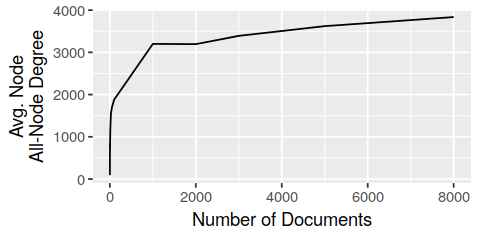

In [33]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node\nAll-Node Degree", stat = "v_degree")
ggsave(filename = "output/syns/snapshot_average_all_node_degree.png", width = 4, height = 2, dpi = 300)

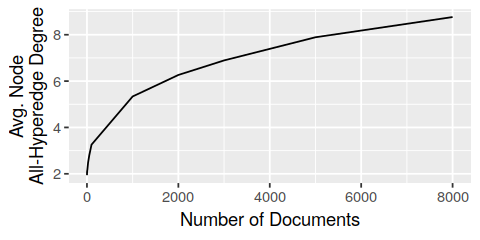

In [34]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node\nAll-Hyperedge Degree", stat = "e_degree")
ggsave(filename = "output/syns/snapshot_average_all_hyperedge_degree.png", width = 4, height = 2, dpi = 300)

#### Average node degree based on directed hyperedges

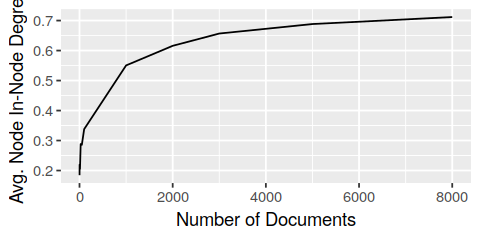

In [35]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node In-Node Degree", stat = "dir_in_v_degree")

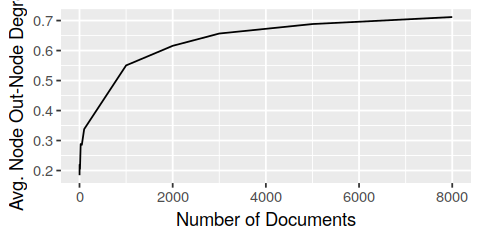

In [36]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node Out-Node Degree", stat = "dir_out_v_degree")

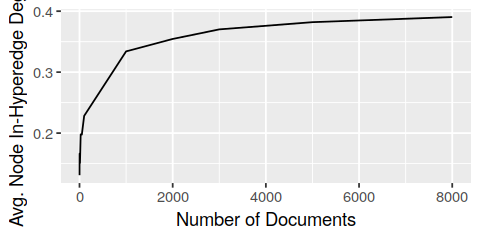

In [37]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node In-Hyperedge Degree", stat = "dir_in_e_degree")

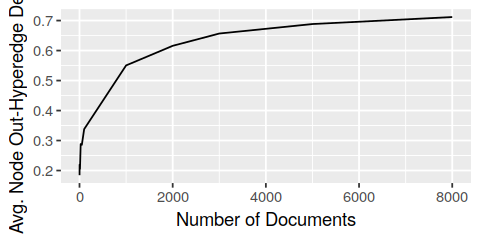

In [38]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node Out-Hyperedge Degree", stat = "dir_out_e_degree")

### Average hyperedge cardinality

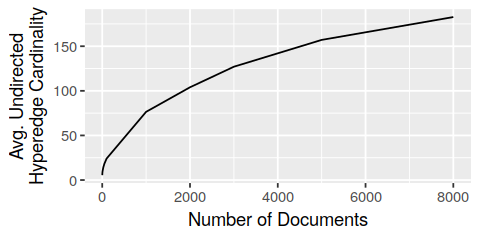

In [39]:
plot_degree_over_time(
    snapshot_edge_degree %>% filter(!is_directed), "Avg. Undirected\nHyperedge Cardinality", stat = "cardinality")
ggsave(filename = "output/syns/snapshot_average_hyperedge_cardinality.png", width = 4, height = 2, dpi = 300)

In [40]:
snapshot_edge_degree %>%
    filter(!is_directed) %>%
    group_by(num_docs) %>%
    summarise(mean=mean(cardinality, na.rm = TRUE))

num_docs,mean
<dbl>,<dbl>
1,5.460000
2,6.565657
3,7.737101
4,7.976690
5,8.944444
10,10.498343
25,14.295672
50,18.394958
100,24.099230


#### Average directed hyperedge cardinalities

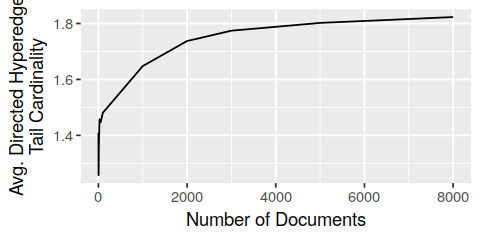

In [41]:
plot_degree_over_time(
    snapshot_edge_degree %>% filter(is_directed),
    "Avg. Directed Hyperedge\nTail Cardinality",
    stat = "tail_cardinality")

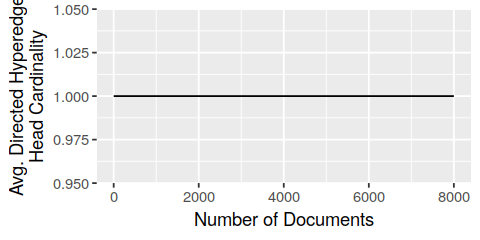

In [42]:
plot_degree_over_time(
    snapshot_edge_degree %>% filter(is_directed),
    "Avg. Directed Hyperedge\nHead Cardinality",
    stat = "head_cardinality")

### Estimated clustering coefficient

In [43]:
load_snapshots_stats_data <- function(base_dir) {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            do.call("load_stats_data", list(base_dir = snapshot_dir)))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    
    setNames(data, c(names(data)[1:3], "statistic", "value"))
}

In [44]:
snapshot_stats <- load_snapshots_stats_data(file.path(base_dir, "snapshots"))
head(snapshot_stats)

snapshot_name,snapshot_id,num_docs,statistic,value
<fct>,<fct>,<dbl>,<chr>,<dbl>
snapshot_001_1,001,1,Vertices,168
snapshot_001_1,001,1,Directed Hyperedges,22
snapshot_001_1,001,1,Undirected Hyperedges,50
snapshot_001_1,001,1,Total Hyperedges,72
snapshot_001_1,001,1,Num Sources,0
snapshot_001_1,001,1,Num Sinks,0


In [45]:
plot_statistics_over_time <- function(data, label, log_scale=FALSE, legend_position = c(0.565, 0.8)) {
    if (length(unique(data$statistic)) > 1) {
        p <- ggplot(data, aes(x=num_docs, y=value, color=statistic)) +
            scale_color_manual("Statistic", values=c("#9673a6", "#82b366")) +
            theme(
                legend.position=legend_position,
                legend.direction="horizontal")
    } else {
        p <- ggplot(data, aes(x=num_docs, y=value))
    }
    
    if (log_scale) {
        p <- p + scale_x_log10() + scale_y_log10()
    }
    
    p + geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}

In [46]:
snapshot_cc <- snapshot_stats[which(snapshot_stats$statistic == "Avg. Clustering Coefficient"), ]
snapshot_cc

,snapshot_name,snapshot_id,num_docs,statistic,value
,<fct>,<fct>,<dbl>,<chr>,<dbl>
17,snapshot_001_1,001,1,Avg. Clustering Coefficient,0.5269253
36,snapshot_002_2,002,2,Avg. Clustering Coefficient,0.4876968
55,snapshot_003_3,003,3,Avg. Clustering Coefficient,0.4968059
74,snapshot_004_4,004,4,Avg. Clustering Coefficient,0.4907480
93,snapshot_005_5,005,5,Avg. Clustering Coefficient,0.4684828
112,snapshot_006_10,006,10,Avg. Clustering Coefficient,0.4375823
131,snapshot_007_25,007,25,Avg. Clustering Coefficient,0.3713977
150,snapshot_008_50,008,50,Avg. Clustering Coefficient,0.3189625
169,snapshot_009_100,009,100,Avg. Clustering Coefficient,0.2608339


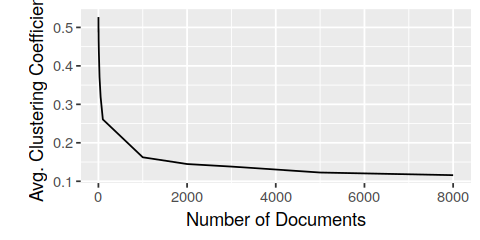

In [47]:
plot_statistics_over_time(snapshot_cc, "\nAvg. Clustering Coefficient")
ggsave(filename = "output/syns/snapshot_avg_clustering_coefficient.png", width = 4, height = 2, dpi = 300)

### Estimated average path length and diameter

In [48]:
snapshot_paths <- snapshot_stats[which(snapshot_stats$statistic %in% c("Avg. Path Length", "Diameter")), ]
snapshot_paths %>% filter(statistic == "Diameter")
snapshot_paths %>% filter(statistic == "Avg. Path Length")

snapshot_name,snapshot_id,num_docs,statistic,value
<fct>,<fct>,<dbl>,<chr>,<dbl>
snapshot_001_1,001,1,Diameter,147
snapshot_002_2,002,2,Diameter,9
snapshot_003_3,003,3,Diameter,7
snapshot_004_4,004,4,Diameter,6
snapshot_005_5,005,5,Diameter,8
snapshot_006_10,006,10,Diameter,13
snapshot_007_25,007,25,Diameter,14
snapshot_008_50,008,50,Diameter,16
snapshot_009_100,009,100,Diameter,16


snapshot_name,snapshot_id,num_docs,statistic,value
<fct>,<fct>,<dbl>,<chr>,<dbl>
snapshot_001_1,001,1,Avg. Path Length,19.633333
snapshot_002_2,002,2,Avg. Path Length,4.133333
snapshot_003_3,003,3,Avg. Path Length,3.833333
snapshot_004_4,004,4,Avg. Path Length,3.766667
snapshot_005_5,005,5,Avg. Path Length,4.333334
snapshot_006_10,006,10,Avg. Path Length,5.566667
snapshot_007_25,007,25,Avg. Path Length,6.300000
snapshot_008_50,008,50,Avg. Path Length,6.166666
snapshot_009_100,009,100,Avg. Path Length,6.200000


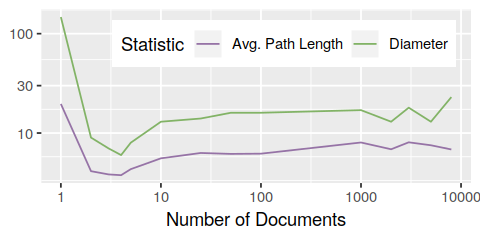

In [49]:
plot_statistics_over_time(snapshot_paths, NULL, log_scale = TRUE)
ggsave(filename = "output/syns/snapshot_avg_shortest_path_stats.png", width = 4, height = 2, dpi = 300)

### General mixed hypergraph density

In [50]:
snapshot_density <- snapshot_stats[which(snapshot_stats$statistic == "Density"), ]
snapshot_density

,snapshot_name,snapshot_id,num_docs,statistic,value
,<fct>,<fct>,<dbl>,<chr>,<dbl>
7,snapshot_001_1,001,1,Density,2.013598e-03
26,snapshot_002_2,002,2,Density,2.269024e-04
45,snapshot_003_3,003,3,Density,1.887150e-04
64,snapshot_004_4,004,4,Density,1.819663e-04
83,snapshot_005_5,005,5,Density,1.276717e-04
102,snapshot_006_10,006,10,Density,6.559216e-05
121,snapshot_007_25,007,25,Density,2.648419e-05
140,snapshot_008_50,008,50,Density,1.777747e-05
159,snapshot_009_100,009,100,Density,1.280265e-05


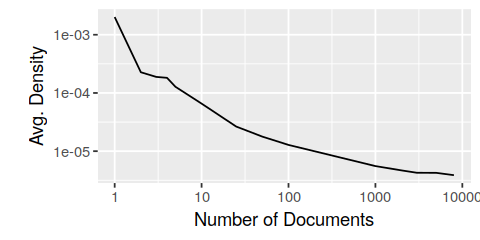

In [51]:
plot_statistics_over_time(snapshot_density, "\nAvg. Density", log_scale = TRUE)
ggsave(filename = "output/syns/snapshot_avg_density.png", width = 4, height = 2, dpi = 300)

### Size and space usage

#### Number of nodes and hyperedges

The growth in number of nodes is sublinear in regard to the number of documents.

In [52]:
snapshot_node_degree %>%
        group_by(num_docs) %>%
        summarize(len=length(node_id))

num_docs,len
<dbl>,<int>
1,168
2,1522
3,1869
4,2031
5,2932
10,5185
25,12724
50,18976
100,29051


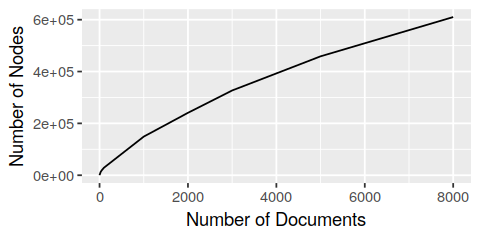

In [53]:
plot_size_over_time(snapshot_node_degree, "Number of Nodes", stat = "node_id")
ggsave(filename = "output/syns/snapshot_num_nodes.png", width = 4.5, height = 2, dpi = 300)

Similarly, the growth in number of hyperedges is sublinear in regard to the number of documents, although there are significantly less hyperedges than nodes.

In [54]:
snapshot_edge_degree %>%
        group_by(num_docs) %>%
        summarize(len=length(edge_id))

num_docs,len
<dbl>,<int>
1,72
2,646
3,718
4,763
5,1056
10,1688
25,4296
50,6129
100,9876


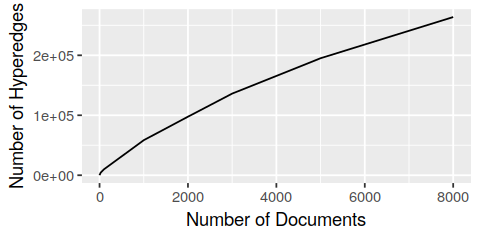

In [55]:
plot_size_over_time(snapshot_edge_degree, "Number of Hyperedges", stat = "edge_id")
ggsave(filename = "output/syns/snapshot_num_hyperedges.png", width = 4.5, height = 2, dpi = 300)

#### Number of bytes in disk and memory

In [56]:
load_snapshots_space_usage_data <- function(base_dir) {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            read.csv(file.path(snapshot_dir, list.files(path = snapshot_dir, pattern = "space-usage-.*\\.csv"))))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    data
}

In [57]:
snapshot_space <- load_snapshots_space_usage_data(file.path(base_dir, "snapshots"))
snapshot_space

snapshot_name,snapshot_id,num_docs,Statistic,Value
<fct>,<fct>,<dbl>,<fct>,<dbl>
snapshot_001_1,001,1,Disk (Bytes),55392
snapshot_001_1,001,1,Memory (Bytes),741553736
snapshot_002_2,002,2,Disk (Bytes),371224
snapshot_002_2,002,2,Memory (Bytes),741553872
snapshot_003_3,003,3,Disk (Bytes),448664
snapshot_003_3,003,3,Memory (Bytes),741553768
snapshot_004_4,004,4,Disk (Bytes),484027
snapshot_004_4,004,4,Memory (Bytes),822083864
snapshot_005_5,005,5,Disk (Bytes),689019


In [58]:
snapshot_space %>%
    filter(Statistic == "Disk (Bytes)") %>%
    summarise(Mean=mean(Value), StdDev=sd(Value)) %>%
    mutate(Mean=paste(round(Mean / 1024^2, 1), "MiB"), StdDev=paste(round(StdDev / 1024^2, 1), "MiB"))

snapshot_space %>%
    filter(Statistic == "Memory (Bytes)") %>%
    summarise(Mean=mean(Value), StdDev=sd(Value)) %>%
    mutate(Mean=paste(round(Mean / 1024^3, 1), "GiB"), StdDev=paste(round(StdDev / 1024^2, 1), "MiB"))

Mean,StdDev
<chr>,<chr>
36.3 MiB,56.6 MiB


Mean,StdDev
<chr>,<chr>
1 GiB,459.5 MiB


In [59]:
plot_space_usage <- function(data, label, stat = "Disk (Bytes)", unit="MB") {
    data <- data %>% filter(Statistic == stat)
    
    stopifnot(unit %in% c("B", "KB", "MB", "GB", "TB"))
    
    if (unit == "B") {
        frac <- 1
    } else if (unit == "KB") {
        frac <- 1024
    } else if (unit == "MB") {
        frac <- 1024^2
    } else if (unit == "GB") {
        frac <- 1024^3
    } else if (unit == "TB") {
        frac <- 1024^4
    }
    
    ggplot(data, aes(x = num_docs, y = Value / frac)) +
        geom_line() +
        scale_y_continuous(label = function(s) paste(s, unit)) +
        xlab("Number of Documents") +
        ylab(label)
}

The growth in disk space is sublinear in regard to the number of documents.

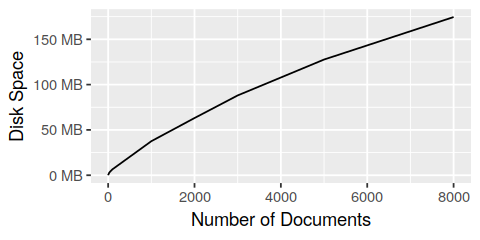

In [60]:
plot_space_usage(snapshot_space, "Disk Space", stat = "Disk (Bytes)")
ggsave(filename = "output/syns/snapshot_disk_space.png", width = 4.5, height = 2, dpi = 300)

The growth in memory space is sublinear in regard to the number of documents, presenting a sharper growth for the first 1000 documents.

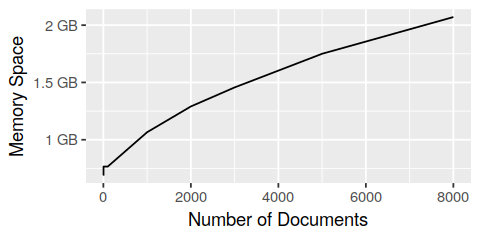

In [61]:
plot_space_usage(snapshot_space, "Memory Space", stat = "Memory (Bytes)", unit = "GB")
ggsave(filename = "output/syns/snapshot_mem_space.png", width = 4.5, height = 2, dpi = 300)